## Question 1: **Answer**

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
def add_data_to_database(data):
    try:
        df = pd.read_csv(data, encoding='unicode_escape')
        # Connecting to database
        engine = sqlite3.connect("university_rankings.db")
        df.to_sql("rankings", con=engine, index = False)
        engine.close()
    except Exception as e:
            print(f'Error: {e}')

# Loading CSV files
data = "/content/national_universities_rankings.csv"
add_data_to_database(data)

Error: Table 'rankings' already exists.


In [3]:
# Loading SQL extension
%load_ext sql
# Connecting to the database
%sql sqlite:///university_rankings.db

In [4]:
# Default to duplicated style
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [5]:
%%sql
SELECT * FROM rankings
LIMIT 5;

 * sqlite:///university_rankings.db
Done.


Name,Location,Rank,Tuition and fees,In-state,Undergrad Enrollment
Princeton University,"Princeton, NJ",1,"$45,320",None,"5,402"
Harvard University,"Cambridge, MA",2,"$47,074",None,"6,699"
University of Chicago,"Chicago, IL",3,"$52,491",None,"5,844"
Yale University,"New Haven, CT",3,"$49,480",None,"5,532"
Columbia University,"New York, NY",5,"$55,056",None,"6,102"


## Question 2: **Answer**

In [6]:
%%sql
CREATE TABLE rankings_copy AS
SELECT * FROM rankings;

 * sqlite:///university_rankings.db
(sqlite3.OperationalError) table rankings_copy already exists
[SQL: CREATE TABLE rankings_copy AS
SELECT * FROM rankings;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [7]:
%%sql
ALTER TABLE rankings_copy
    RENAME 'Name' to 'name';

ALTER TABLE rankings_copy
    RENAME 'Location' to 'location';

ALTER TABLE rankings_copy
    RENAME 'Rank' to 'rank';

ALTER TABLE rankings_copy
    RENAME 'Tuition and fees' to 'tuition_and_fees';

ALTER TABLE rankings_copy
    RENAME 'In-state' to 'in_state';

ALTER TABLE rankings_copy
    RENAME 'Undergrad Enrollment' to 'undergrad_enrollment';

 * sqlite:///university_rankings.db
Done.
Done.
Done.
(sqlite3.OperationalError) no such column: "Tuition and fees"
[SQL: ALTER TABLE rankings_copy
    RENAME 'Tuition and fees' to 'tuition_and_fees';]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [8]:
%%sql
SELECT * FROM rankings_copy
LIMIT 5

 * sqlite:///university_rankings.db
Done.


name,location,rank,tuition_and_fees,in_state,undergrad_enrollment
Princeton University,"Princeton, NJ",1,"$45,320",None,"5,402"
Harvard University,"Cambridge, MA",2,"$47,074",None,"6,699"
University of Chicago,"Chicago, IL",3,"$52,491",None,"5,844"
Yale University,"New Haven, CT",3,"$49,480",None,"5,532"
Columbia University,"New York, NY",5,"$55,056",None,"6,102"


## Question 3: **Answer**

In [9]:
%%sql
SELECT
    ROUND(AVG(CASE WHEN in_state IS NOT NULL THEN 1.0 ELSE 0.0 END) * 100, 2)
    AS percentage_with_in_state_fees,
    ROUND(AVG(CASE WHEN in_state IS NULL THEN 1.0 ELSE 0.0 END) * 100, 2)
    AS percentage_no_state_fees
FROM rankings_copy;

 * sqlite:///university_rankings.db
Done.


percentage_with_in_state_fees,percentage_no_state_fees
57.58,42.42


 ## Question 4: **Answer**

In [10]:
%%sql
-- Creating two categories and aggregate students
WITH categories_fees_status AS (
    SELECT
        CASE
            WHEN in_state IS NOT NULL THEN 'With In-State Fees'
            ELSE 'Without In-State Fees'
        END AS fee_category,
        SUM(REPLACE(undergrad_enrollment, ',', '')) AS total_students
    FROM rankings_copy
    GROUP BY fee_category
),
-- Calculating total students
total_students AS (
    SELECT
        SUM(total_students) AS all_students
    FROM categories_fees_status
)
-- Calculating percentage per category
SELECT
    fee_category,
    ROUND((total_students * 100.0) / (SELECT all_students
                                      FROM total_students), 2)
    AS percentage
FROM categories_fees_status;

 * sqlite:///university_rankings.db
Done.


fee_category,percentage
With In-State Fees,80.44
Without In-State Fees,19.56


## Question 5: **Answer**

In [11]:
%%sql
-- University name, rank and total fees
WITH ranked_universities AS (
    SELECT
        name,
        rank,
        CAST(REPLACE(REPLACE(tuition_and_fees, '$', ''), ',','') AS REAL) AS tuition,
        CAST(REPLACE(undergrad_enrollment, ',','') AS INTEGER) AS undergrad_enrollment
    FROM rankings_copy
),
-- Calculate total tuition fees for top 3 ranked universities
top_3_tuition AS (
    SELECT
        SUM(tuition * undergrad_enrollment) AS total_tuition_top_3
    FROM ranked_universities
    WHERE rank IN (1, 2, 3)
),
-- Calculate total tuition fees for bottom 3 ranked universities
bottom_3_tuition AS (
    SELECT
        SUM(tuition * undergrad_enrollment) AS total_tuition_bottom_3
    FROM ranked_universities
    WHERE rank IN (SELECT DISTINCT(rank)
                    FROM ranked_universities
                    ORDER BY rank DESC
                    LIMIT 3 )
)
-- Returning top ranked, bottom ranked fees and difference
SELECT
    total_tuition_top_3,
    total_tuition_bottom_3,
    ABS(total_tuition_top_3 - total_tuition_bottom_3) AS difference
FROM top_3_tuition
JOIN bottom_3_tuition
ON 1=1;

 * sqlite:///university_rankings.db
Done.


total_tuition_top_3,total_tuition_bottom_3,difference
1140648130.0,5932622264.0,4791974134.0


## Question 6: **Answer**

In [12]:
%%sql
-- Clean columns and calculate total fees
WITH calculate_total_fees AS (
    SELECT
        name,
        CAST(REPLACE(REPLACE(tuition_and_fees, '$', ''), ',', '') AS INTEGER) *
        CAST(REPLACE(undergrad_enrollment, ',', '') AS INTEGER) AS total_fees
    FROM rankings_copy

),
-- Rank schools based on total fees raised
school_rank AS(
    SELECT
        name,
        total_fees,
        RANK() OVER (ORDER BY total_fees) AS rank
    FROM calculate_total_fees
)
-- Return the schools with highest and lowest ranks
SELECT
    FIRST_VALUE(name) OVER (ORDER BY rank DESC) AS highest_ranked_sch,
    FIRST_VALUE(total_fees) OVER (ORDER BY rank DESC) AS highest_total_fees,

    LAST_VALUE(name) OVER (ORDER BY rank DESC ROWS BETWEEN UNBOUNDED PRECEDING AND
                                        UNBOUNDED FOLLOWING) AS lowest_ranked_sch,
    LAST_VALUE(total_fees) OVER (ORDER BY rank DESC ROWS BETWEEN UNBOUNDED PRECEDING
                                        AND UNBOUNDED FOLLOWING) AS lowest_total_fees
FROM school_rank
LIMIT 1;

 * sqlite:///university_rankings.db
Done.


highest_ranked_sch,highest_total_fees,lowest_ranked_sch,lowest_total_fees
Michigan State University,1530099870,SUNY College of Environmental Science and Forestry,32403180


## Part B: **Answer**

In [13]:
query = """
WITH calculate_total_fees AS (
    SELECT
        name,
        CAST(REPLACE(REPLACE(tuition_and_fees, '$', ''), ',', '') AS INTEGER) *
        CAST(REPLACE(undergrad_enrollment, ',', '') AS INTEGER) AS total_fees
    FROM rankings_copy

),
-- Rank schools based on total fees raised
school_rank AS(
    SELECT
        name,
        total_fees,
        RANK() OVER (ORDER BY total_fees) AS rank
    FROM calculate_total_fees
)
-- Return the schools with highest and lowest ranks
SELECT
    FIRST_VALUE(name) OVER (ORDER BY rank DESC) AS highest_ranked_sch,
    FIRST_VALUE(total_fees) OVER (ORDER BY rank DESC) AS highest_total_fees,

    LAST_VALUE(name) OVER (ORDER BY rank DESC ROWS BETWEEN UNBOUNDED PRECEDING AND
                                        UNBOUNDED FOLLOWING) AS lowest_ranked_sch,
    LAST_VALUE(total_fees) OVER (ORDER BY rank DESC ROWS BETWEEN UNBOUNDED PRECEDING
                                        AND UNBOUNDED FOLLOWING) AS lowest_total_fees
FROM school_rank
LIMIT 1;

"""

In [14]:
# Creating connection to the database
connection = sqlite3.connect("university_rankings.db")
# Creating a Dataframe from query
df = pd.read_sql_query(query, connection)
print(df)

          highest_ranked_sch  highest_total_fees  \
0  Michigan State University          1530099870   

                                   lowest_ranked_sch  lowest_total_fees  
0  SUNY College of Environmental Science and Fore...           32403180  


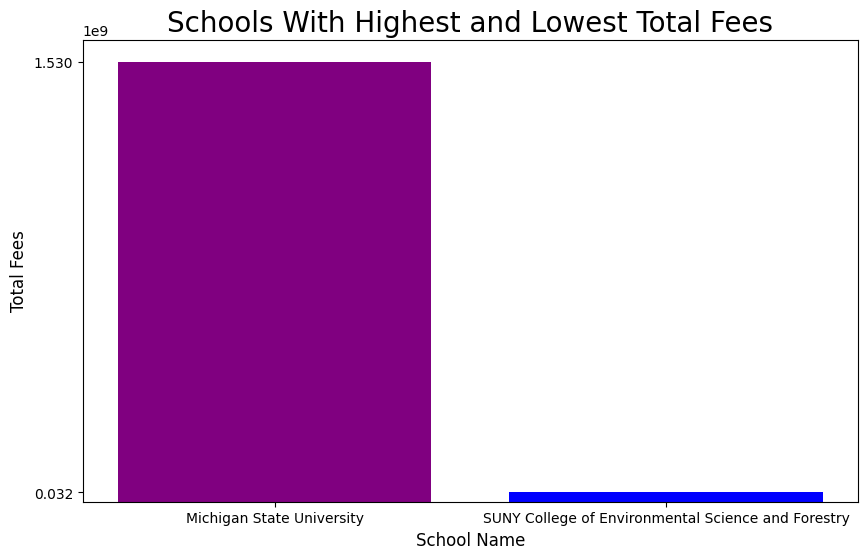

In [15]:
# Retrieving names from the DataFrame
sch_names = [df['highest_ranked_sch'][0], df['lowest_ranked_sch'][0]]
# Retrieving values from the DataFrame
values = [df['highest_total_fees'][0], df['lowest_total_fees'][0]]

# Creating a plot
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(sch_names, values, label = sch_names, color = ["Purple", "Blue"])
ax.set_ylabel("Total Fees", fontsize= 12)
ax.set_xlabel("School Name", fontsize= 12)
ax.set_yticks(values)
plt.title("Schools With Highest and Lowest Total Fees", fontsize = 20)
plt.show()
connection.close()

## Question 7: **Answer**

In [16]:
%%sql
WITH RECURSIVE cumulative_enrollment AS (
    -- Starting with the highest-ranked university
    SELECT
        rank,
        CAST(REPLACE(undergrad_enrollment, ',', '') AS INTEGER)
        AS cumulative_enrollment
    FROM rankings_copy
    WHERE rank = 1

    UNION ALL

    -- Adding the enrollment of the next university in rank order
    SELECT
        r.rank,
          c.cumulative_enrollment + CAST(REPLACE(r.undergrad_enrollment, ',', '') AS INTEGER)
        AS cumulative_enrollment
    FROM cumulative_enrollment c
    JOIN rankings_copy r
    ON r.rank = c.rank + 1
    WHERE r.rank <= 3
)
SELECT
    MAX(cumulative_enrollment) AS max_cumulative_enrollment_total
FROM cumulative_enrollment;

 * sqlite:///university_rankings.db
Done.


max_cumulative_enrollment_total
17945


In [17]:
# %%sql
# DROP TABLE rankings_copy;

In [18]:
# %%sql
# DROP TABLE rankings;